from dotenv import load_dotenv
load_dotenv()

import os
key = os.getenv('GOOGLE_API_KEY')

In [2]:
from dataclasses import dataclass
from datetime import datetime
from typing import Optional

@dataclass
class Comment:
    comment_id: str
    author: str
    text: str
    like_count: int
    published_at: datetime
    parent_id: Optional[str]

In [3]:
import requests
from typing import List

def get_top_level_comments(video_id) -> List[Comment]:
    url = 'https://www.googleapis.com/youtube/v3/commentThreads'
    order = 'relevance'
    params = {
        'key': key,
        'part': 'snippet',
        'videoId': video_id,
        'maxResults': 100,
        'order': order,
    }
    
    comments = []
    response = requests.get(url, params=params)
    data = response.json()
    for item in data['items']:
        top_comment = item['snippet']['topLevelComment']['snippet']
        snippet_id = item['id']
        author = top_comment['authorDisplayName']
        text = top_comment['textDisplay']
        like_count = top_comment['likeCount']
        published_at = top_comment['publishedAt']

        comments.append(Comment(snippet_id, author, text, like_count, published_at, None))
    return comments

In [4]:
# video_id = 'NDsO1LT_0lw' # mr beast
video_id = 'YbJOTdZBX1g' # yt rewind 2018

top_level_comments = get_top_level_comments(video_id)
top_level_comments[:5]

[Comment(comment_id='UgyBjLLdTju8FbrdW314AaABAg', author='@Rxaches4lunch', text='2018: we tried but failed horribly<br>2019: we didn’t even try<br>2020: we didn’t even make one', like_count=129641, published_at='2020-11-12T22:37:59Z', parent_id=None),
 Comment(comment_id='Ugyl9eWxxbM04WBrUop4AaABAg', author='@2075anant', text='The irony is that YouTube created the most disliked video on YouTube. Can&#39;t get enough of that.', like_count=54990, published_at='2021-06-03T09:58:21Z', parent_id=None),
 Comment(comment_id='UgzPTxvCQortnOaf1wd4AaABAg', author='@kud4262', text='Every year youtube just keeps getting disconnected from its content creators.', like_count=210609, published_at='2018-12-07T22:16:16Z', parent_id=None),
 Comment(comment_id='UgwfAGAyka6E9AAYfQN4AaABAg', author='@NormalChannel95', text='I miss when this was our biggest worry.', like_count=1215, published_at='2025-03-02T18:55:07Z', parent_id=None),
 Comment(comment_id='UgzuRQReymfJpHjItjt4AaABAg', author='@pendragonandje

In [5]:
def get_replies(comment_id: str) -> List[Comment]:
    url = 'https://www.googleapis.com/youtube/v3/comments'
    params = {
        'key': key,
        'part': 'snippet',
        'parentId': comment_id,
        'maxResults': 100
    }

    replies: List[Comment] = []

    while 1:
        response = requests.get(url, params=params)
        data = response.json()

        for item in data.get('items', []):
            snippet = item['snippet']
            replies.append(Comment(
                comment_id=item['id'],
                author=snippet.get('authorDisplayName', ''),
                text=snippet.get('textDisplay', ''),
                like_count=snippet.get('likeCount', 0),
                published_at=datetime.strptime(snippet['publishedAt'], "%Y-%m-%dT%H:%M:%SZ"),
                parent_id=snippet.get('parentId')
            ))

        if 'nextPageToken' in data:
            params['pageToken'] = data['nextPageToken']
        else:
            break

    replies.sort(key=lambda c: c.like_count, reverse=True)
    return replies

In [6]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
text = "test"
score = sia.polarity_scores(text)

print(score)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ltera/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
import html
import re
from googletrans import Translator
from langdetect import detect

async def text_cleanup(text):
    text = html.unescape(text)  # decode HTML entities
    text = re.sub(r'@\w+', '', text)  # remove @mentions

    translator = Translator()

    try:
        if detect(text) != 'en':
            translation = await translator.translate(text, dest='en')
            text = translation.text
    except Exception:
        pass 

    text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove emojis
    text = re.sub(r'[^a-zA-Z,\s]', '', text)  # remove non-alpha except commas and space
    text = re.sub(r'\s+', ' ', text)  # normalize spacing

    return text.strip()

In [8]:
import asyncio

async def analyze_comment_sentiment(comment):
    preprocessed_text = await text_cleanup(comment.text)
    return sia.polarity_scores(preprocessed_text)

print(top_level_comments[1])
analyze_comment_sentiment(top_level_comments[1])

Comment(comment_id='Ugyl9eWxxbM04WBrUop4AaABAg', author='@2075anant', text='The irony is that YouTube created the most disliked video on YouTube. Can&#39;t get enough of that.', like_count=54990, published_at='2021-06-03T09:58:21Z', parent_id=None)


<coroutine object analyze_comment_sentiment at 0x7fb56f2797d0>

In [9]:
pnng = [0]*3
n = 10 # only output first n comments

for comment in top_level_comments:
    score = await analyze_comment_sentiment(comment)
    if score['pos'] > score['neg']:
        sentiment = 'POSITIVE'
        pnng[0] += 1
    elif score['neg'] > score['pos']:
        sentiment = 'NEGATIVE'
        pnng[2] += 1
    else:
        sentiment = 'NEUTRAL'
        pnng[1] += 1

    if n > 0:
        print(f'{sentiment}: {comment}\n{score}\n')

    n -= 1

NEGATIVE: Comment(comment_id='UgyBjLLdTju8FbrdW314AaABAg', author='@Rxaches4lunch', text='2018: we tried but failed horribly<br>2019: we didn’t even try<br>2020: we didn’t even make one', like_count=129641, published_at='2020-11-12T22:37:59Z', parent_id=None)
{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'compound': -0.6652}

NEGATIVE: Comment(comment_id='Ugyl9eWxxbM04WBrUop4AaABAg', author='@2075anant', text='The irony is that YouTube created the most disliked video on YouTube. Can&#39;t get enough of that.', like_count=54990, published_at='2021-06-03T09:58:21Z', parent_id=None)
{'neg': 0.208, 'neu': 0.693, 'pos': 0.099, 'compound': -0.2944}

NEUTRAL: Comment(comment_id='UgzPTxvCQortnOaf1wd4AaABAg', author='@kud4262', text='Every year youtube just keeps getting disconnected from its content creators.', like_count=210609, published_at='2018-12-07T22:16:16Z', parent_id=None)
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

NEGATIVE: Comment(comment_id='UgwfAGAyka6E9AAYfQN4AaABAg', auth

[33, 26, 41]


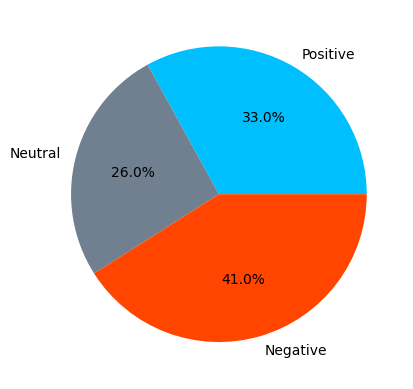

In [10]:
import matplotlib.pyplot as plt

labels = 'Positive', 'Neutral', 'Negative'
fig, ax = plt.subplots()
ax.pie(pnng, labels=labels, autopct='%1.1f%%', colors=['deepskyblue','slategray','orangered'])
print(pnng)

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.documents import Document

def openai_summarize(comments):
    docs = [Document(page_content=comment.text) for comment in comments]
    
    prompt = ChatPromptTemplate.from_messages(
        [("system", "Write a summary of the following youtube comments. Highlight specific comments and preserve user sentiment:\\n\\n{context}")]
    )
    
    llm = ChatOpenAI(model_name="gpt-4", temperature=0.5)
    chain = create_stuff_documents_chain(llm, prompt)

    result = chain.invoke({"context": docs})
    
    return result

In [13]:
s = True
if s:
    summary = openai_summarize(top_level_comments)
    print(summary)

The comments reflect a general dissatisfaction with YouTube's Rewind videos, particularly the 2018 and 2019 editions. Users feel YouTube is disconnected from its content creators and community, with one user stating, "Every year YouTube just keeps getting disconnected from its content creators." Many comments highlight the irony of YouTube creating the most disliked video on its platform, and express disappointment at the removal of the dislike button, which they believe was a response to the negative reception of the Rewind videos. They also criticize the absence of popular YouTubers like PewDiePie and the inclusion of irrelevant content. Some users, however, express a sense of nostalgia for the Rewind videos and suggest they were not as bad in hindsight. A few comments also humorously note the high number of dislikes, with one user saying, "Fun fact: There are more dislikes on this video than people in the entire country of Kazakhstan."
